In [12]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

from pyspark.sql import SparkSession
import axs

import pyspark.sql.functions as sparkfunc
from functools import partial
from pyspark.sql.functions import udf
from pyspark.sql.types import *
from pyspark.sql.functions import mean as _mean, stddev as _stddev, col
from pyspark.sql.functions import size

from fit import preprocess, fit_band, plot_model

In [3]:
spark = ( 
    SparkSession
    .builder
    .config("spark.master", "local[*]")
    .config("spark.driver.memory", "120g")
    .config("spark.driver.maxResultSize", "0")
    .enableHiveSupport()
    .getOrCreate()
)

In [4]:
import socket
port = spark.sparkContext.uiWebUrl.split(":")[-1]
hostname = socket.gethostname()
print(f"https://{hostname}/jupyter/user/stevengs/proxy/{port}/jobs/")

https://epyc.astro.washington.edu/jupyter/user/stevengs/proxy/4043/jobs/


In [5]:
catalog = axs.AxsCatalog(spark)

Full dip catalog from ZTF dataset

In [6]:
wtf = catalog.load('wtf_march2020_full_3')

Kyle's cuts for dips we're interested in

In [7]:
# Select the good dippers with a set of cuts tuned to
# pull out what we are looking for.
cut_catalog_name = "stevengs_cut_wtf"
if cut_catalog_name not in catalog.list_table_names():
    cut_wtf = (
        wtf
        .where(
            (sparkfunc.col("dip.significance") >= 5)
            & (sparkfunc.col("dip.significant_observation_count") >= 3)

            & (sparkfunc.col("dip.max_gap_fraction") < 0.8)

            & (sparkfunc.col("dip.core_length") >= 0.5)
            & (sparkfunc.col("dip.core_not_significant_fraction") < 0.2)
            & (sparkfunc.col("dip.core_significant_count") > 3.)

            & (sparkfunc.col("dip.ref_pull_std") < 2.)
            & (sparkfunc.col("dip.ref_length_fraction_before") > 0.5)
            & (sparkfunc.col("dip.ref_length_fraction_after") > 0.5)
        )
    )
    catalog.save_axs_table(cut_wtf, cut_catalog_name)
else:
    cut_wtf = catalog.load(cut_catalog_name)

Fit r-band light curve in a window around the dip. The window is extended by 4x the dip width on either side of the dip.

In [13]:
band = "r"
fit_catalog_name = f"stevengs_cut_wtf_fits_{band}_band"
if fit_catalog_name not in catalog.list_table_names():
    wiggle = 4.0
    df_fit = preprocess(cut_wtf, [band])
    df_fit = fit_band(df_fit, band, wiggle)
    catalog.save_axs_table(df_fit,  fit_catalog_name)
else:
    df_fit = catalog.load(fit_catalog_name)

StructType(List(StructField(good_fit,BooleanType,false),StructField(message,StringType,false),StructField(chi_square,FloatType,false),StructField(chi_square_reduced,FloatType,false),StructField(runtime,FloatType,false),StructField(params,StructType(List(StructField(skew,FloatType,true),StructField(loc,FloatType,true),StructField(xscale,FloatType,true),StructField(yscale,FloatType,true),StructField(offset,FloatType,true))),true),StructField(params_init,StructType(List(StructField(skew_init,FloatType,true),StructField(loc_init,FloatType,true),StructField(xscale_init,FloatType,true),StructField(yscale_init,FloatType,true),StructField(offset_init,FloatType,true))),true)))


In [14]:
chi_sq = df_fit.select(df_fit['fit_r']['chi_square_reduced']).collect()

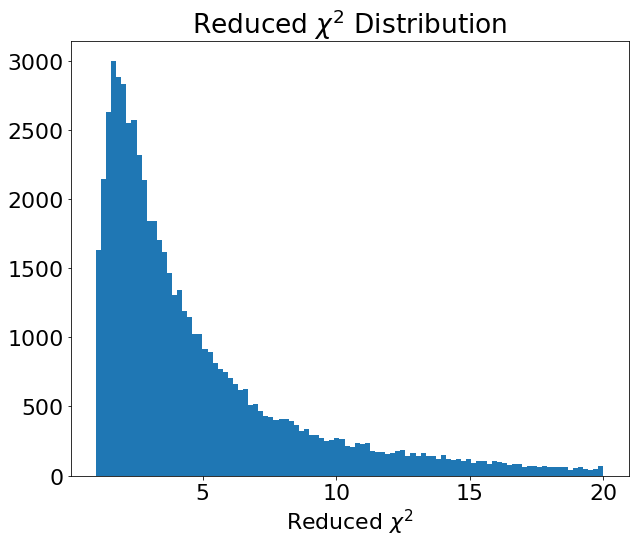

In [16]:
plt.rc("figure", figsize=[10, 8])
plt.rc("font", size=22)
plt.hist([_['fit_r.chi_square_reduced'] for _ in chi_sq], bins=100, range=(1, 20))
plt.title("Reduced $\chi^2$ Distribution")
plt.xlabel("Reduced $\chi^2$")
plt.show()